## Initialization

In [2]:
#from Classes import Data, Assignment
    # Later, we can move the Class definitions into a separate file

In [3]:
%pip install pulp

# Install Gurobi
%pip install gurobipy 
    # Obtain academic license from: https://www.gurobi.com/downloads/end-user-license-agreement-academic/

# Install SCIP
%pip install pyscipopt

# Other useful packages
import numpy as np
import pandas as pd
import copy # To make deep copies
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Check with solvers available on computer
import pulp as pl
from pulp import *
solver_list = pl.listSolvers(onlyAvailable=True)
print(solver_list)

['GUROBI', 'GUROBI_CMD', 'PULP_CBC_CMD', 'SCIP_CMD', 'FSCIP_CMD', 'SCIP_PY']


## Define classes
Define the following classes:
* 'Data': contains
    * Number of students
    * Number of schools
    * Preferences students
    * Preferences schools
    * Capacities schools
    * Names of students
    * Names of schools
    * File name
* 'Assignment': the selection probabilities of the students to the schools

In [6]:
class Data:
    # Define the initialization of an object from this class
    def __init__(self, n_stud: int, n_schools: int, pref: list, prior: list, cap:list, ID_stud:list, ID_school:list, file_name:str):
        self.n_stud = n_stud
        self.n_schools = n_schools
        self.pref = copy.deepcopy(pref)
        self.prior = copy.deepcopy(prior)
        self.cap = copy.deepcopy(cap)
        self.ID_stud = copy.deepcopy(ID_stud)
        self.ID_school = copy.deepcopy(ID_school)
        self.file_name = file_name   

        # Create alternative copies of pref and prior in which the elements are no longer strings, 
        # but the indices of the corresponding elements in the ID vectors
        self.pref_index = [[self.ID_school.index(school) for school in student_pref] for student_pref in self.pref]

        # Now create two matrices containing the position of the schools in the preferences, and of the students in the priorities
        # Initialize the rank matrix with NaN
        self.rank_pref = np.full((self.n_stud, self.n_schools), np.nan)

        self.prior_index = []
        for school_prior in self.prior:
            transformed_school_prior = []
            for student_group in school_prior:
                if isinstance(student_group, tuple):
                    transformed_school_prior.append(tuple(ID_stud.index(student) for student in student_group))
                else:
                    transformed_school_prior.append(ID_stud.index(student_group))
            self.prior_index.append(transformed_school_prior)

        
        # Populate the rank matrix
        for i, student_pref in enumerate(self.pref):
            for rank_position, school_id in enumerate(student_pref):
                if school_id in self.ID_school:
                    school_index = self.ID_school.index(school_id)
                    self.rank_pref[i][school_index] = rank_position

        # Initialize the rank_prior matrix with NaN
        self.rank_prior = np.full((self.n_schools, self.n_stud), np.nan)
        
        # Populate the rank_prior matrix
        for j, school_prior in enumerate(self.prior):
            for rank_position, student_id in enumerate(school_prior):
                # Handle tuple (grouped students) by expanding
                if isinstance(student_id, tuple):
                    for grouped_student in student_id:
                        if grouped_student in self.ID_stud:
                            student_index = self.ID_stud.index(grouped_student)
                            self.rank_prior[j][student_index] = rank_position + 1  # Positions are 1-based
                elif student_id in self.ID_stud:
                    student_index = self.ID_stud.index(student_id)
                    self.rank_prior[j][student_index] = rank_position + 1  # Positions are 1-based
        
        

    
    # Choose what is being shown for the command 'print(MyData)', where 'MyData' is an instance of the class 'Data'
    def __str__(self):
        s ="The data instance has the following properties: \n"
        s += f"\n\t{self.n_stud} students.\n\t{self.n_schools} schools. \n\n \tPREFERENCES:\n"
        for i in range(0,self.n_stud):
            s+= f"\t{self.ID_stud[i]}\t"
            for j in range(0, len(self.pref[i])):
                if len(self.pref[i][j]) >= 2:
                    s+=f"{{"
                    for k in range(0, len(self.pref[i][j])):
                        s+=f"{self.pref[i][j][k]}"
                        if k < len(self.pref[i][j]) - 1:
                            s+= f" "
                    s+=f"}} "
                else:
                    s+=f"{self.pref[i][j]} "
            s +="\n"

        s += f"\n\n \tCAPACITIES & PRIORITIES:\n"
        for i in range(0,self.n_schools):
            s+= f"\t{self.ID_school[i]}\t"
            s+= f"{self.cap[i]}\t"
            for j in range(0, len(self.prior[i])):
                if len(self.prior[i][j]) >= 2:
                    s+=f"{{"
                    for k in range(0, len(self.prior[i][j])):
                        s+=f"{self.prior[i][j][k]}"
                        if k < len(self.prior[i][j]) - 1:
                            s+= f" "
                    s+=f"}} "
                else:
                    s+=f"{self.prior[i][j]} "
            s +="\n"
        return s

In [7]:
class Assignment:
    # This class will contain an assignment
    def __init__(self, MyData: Data, p: np.ndarray, label = None):
        # self.file_name = MyData.file_name[:-4] 
            # Use this when importing .csv files, for example
        self.file_name = MyData.file_name
        self.MyData = copy.deepcopy(MyData)
        self.assignment = copy.deepcopy(p)
        self.label = label
        if label == None:
            self.label = ""
        
        names = []
        for i in range(0,MyData.n_stud):
            names.append("Choice {}".format(i + 1))
        
        # Same as assignment, but ranked in decreasing order of preference
        self.assignment_ranked = np.zeros(shape=(MyData.n_stud, MyData.n_schools), dtype = np.float64)
        counter =  0
        for i in range(0, MyData.n_stud):
            for j in range(0, len(MyData.pref[i])):
                
                # Convert pref[i][k] (school ID as string) to column index
                col_index = int(MyData.pref[i][j]) - 1
                self.assignment_ranked[i][j] = self.assignment[i][col_index]
                counter += 1
        #self.assignment_ranked = pd.DataFrame(ranked, columns = names)

    
        # Export assignment
        self.export_assignment()
    
    # Visualize the assignment in different ways
    def visualize(self):
        # To export the figures, check if the correct folder exists:
        if os.path.exists("Results") == False:
            # If not, create folder
            os.makedirs("Results")
        
        s = os.path.join("Results", "Visualisations")
        if os.path.exists(s) == False:
            # If not, create folder
            os.makedirs(s)
        
        s = os.path.join("Results", "Visualisations",self.file_name)
        if os.path.exists(s) == False:
            os.makedirs(s)
            
        
        path = "Results/Visualisations/"
        # The assignment itself
        sns.set(rc = {'figure.figsize':(MyData.n_stud,MyData.n_schools/1.5)})
        
        # Create a custom colormap (to show negative values red)
        colors = ["red", "white", "blue"]  # Red for negatives, white for 0, blue for positives
        custom_cmap = LinearSegmentedColormap.from_list("CustomMap", colors)
        
        # Create the heatmap
        p = sns.heatmap(self.assignment, cmap = custom_cmap, center=0, annot=True, yticklabels = MyData.ID_stud, xticklabels = MyData.ID_school)
        p.set_xlabel("Students", fontsize = 15)
        p.set_ylabel("Schools", fontsize = 15)
        name = path + self.file_name + "/" + self.label + ".pdf"
        p.set_title(self.label, fontsize = 20)
        plt.savefig(name, format="pdf", bbox_inches="tight")
        
        # Assignment, ranked by preference
        plt.figure()

        # Create a custom colormap (to show negative values red)
        colors = ["red", "white", "green"]  # Red for negatives, white for 0, blue for positives
        custom_cmap2 = LinearSegmentedColormap.from_list("CustomMap", colors)
        
        # Create the heatmap
        sns.set(rc = {'figure.figsize':(MyData.n_stud,MyData.n_schools/1.5)})
        p = sns.heatmap(self.assignment_ranked, cmap = custom_cmap2, center=0, annot=True, yticklabels = MyData.ID_stud, xticklabels = range(1,MyData.n_schools + 1))
        p.set_xlabel("Preference", fontsize = 15)
        p.set_ylabel("Students", fontsize = 15)
        name = path + self.file_name + "/" + self.label + "_Ranked.pdf"
        title = self.file_name + ": ranked by decreasing preference"
        p.set_title(title, fontsize = 20)
        plt.savefig(name, format="pdf", bbox_inches="tight")
        
        plt.figure()
    
    # Save the assignment to the correct subdirectory
    def export_assignment(self):
        if os.path.exists("Results") == False:
            # If not, create folder
            os.makedirs("Results")

        s = os.path.join("Results", "Assignments")
        if os.path.exists(s) == False:
            # If not, create folder
            os.makedirs(s)

        s = os.path.join("Results", "Assignments",self.file_name)
        if os.path.exists(s) == False:
            os.makedirs(s)
        
        name = "Results/Assignments/" + self.file_name + "/" + self.label + "_" + self.file_name + ".csv"
        np.savetxt(name, self.assignment, delimiter=",")
        
    # Choose what is being shown for the command 'print(Sol)', where 'Sol' is an instance of the class 'Assignment'
    def __str__(self):
        
        return s
        

In [78]:
class Model: 
    """
    Contains two methods:
        __init__: initializes the model, and the solver environment

        Solve: solves the model.
            The parameters of this method can control which objective function is optimized, and which solver is used
    """
    
    # Used this example as a template for Pulp: https://coin-or.github.io/pulp/CaseStudies/a_sudoku_problem.html
    
    def __init__(self, MyData: Data, p: Assignment, print_out: bool, nr_matchings = -1):
        """
        Initialize an instance of Model.

        Args:
            MyData (type: Data): instance of class Data.
            p (type: Assignment): instance of class Assignment.
            print_out (type: bool): boolean that controls which output is printed.
            nr_matchings (optional): number of matchings used in the decomposition, optional parameter that defaults to n_students * n_schools + 1

        """
        # 'nr_matchings' refers to number of matchings used to find decomposition
        self.MyData = copy.deepcopy(MyData)
        self.p = copy.deepcopy(p)
        self.nr_matchings = nr_matchings
        if nr_matchings == -1:
            self.nr_matchings = self.MyData.n_stud * self.MyData.n_schools + 1

        # Create the pulp model
        self.model = LpProblem("Improving_ex_post_stable_matchings", LpMinimize)

        #### DECISION VARIABLES ####
        self.STUD = range(0,self.MyData.n_stud)
        self.SCHOOLS = range(0, self.MyData.n_schools)
        self.N_MATCH = range(0, self.nr_matchings)

        # Tuple with all student-school pairs that are preferred to outside option
        self.PAIRS = []
        for i in range(0, MyData.n_stud):
            for j in range(0,len(MyData.pref[i])):
        
                # Convert pref[i][k] (school ID as string) to column index
                col_index = int(MyData.pref[i][j]) - 1
                self.PAIRS.append((i,col_index))

        if print_out == True:
            # Compute average rank of current assignment

            sum = 0
            for (i,j) in self.PAIRS:
                sum += self.p[i,j] * (self.MyData.rank_pref[i,j] + 1) # + 1 because the indexing starts from zero
            # Average
            sum = sum/self.MyData.n_stud
            print(f"\nAverage rank before optimization: {sum}.\n\n")
              
        
        # M[k][i][j] = 1 if student i is assigned to school j in matching k, and 0 otherwise
        self.M = LpVariable.dicts("M", [(k, i, j) for k in self.N_MATCH for i, j in self.PAIRS], cat="Binary")

        # Auxiliary variables to avoid non-linearity
        self.z = LpVariable.dicts("z", [(k, i, j) for k in self.N_MATCH for (i, j) in self.PAIRS])

        # Rename M and z
        for k, i, j in self.M:
            student_name = self.MyData.ID_stud[i]
            school_name = self.MyData.ID_school[j]
            self.M[k, i, j].name = f"M_{k}_{student_name}_{school_name}"
            self.z[k, i, j].name = f"z_{k}_{student_name}_{school_name}"

        # Q[i][j] is the new probability with which student i is assigned to school j, lies between 0 and 1
        self.Q = LpVariable.dicts("q", self.PAIRS, 0, 1) 
    
        # w[k] is the weight of matching k in the decomposition
        self.w = LpVariable.dicts("w", self.N_MATCH, 0, 1)

        #### OBJECTIVE FUNCTION ####
            # Done separately in other functions (see function Solve)
        
            
        #### CONSTRAINTS ####
        
        # Stability
        for k in self.N_MATCH:
            for i in self.STUD:
                for j in range(len(self.MyData.pref_index[i])):
                    current_school = self.MyData.pref_index[i][j]
                    lin = LpAffineExpression()

                    lin += self.M[k, i, current_school]

                    # Add all schools that are at least as preferred as the j-ranked school by student i
                    for l in range(j):
                        lin += self.MyData.cap[current_school] * self.M[k,i,self.MyData.pref_index[i][l]]


                    # Add terms based on priorities
                    prior_current = self.MyData.rank_prior[current_school][i]
                    for s in self.STUD:
                        if s != i:
                            # If current_school ranks student s higher than student i
                            if self.MyData.rank_prior[current_school][s] <= self.MyData.rank_prior[current_school][i]:
                                if (s, current_school) in self.PAIRS:
                                    lin += self.M[k,s,current_school]

                    # Add to model:
                    name = "STAB_" + str(k) + "_" + self.MyData.ID_stud[i] + "_" + self.MyData.ID_school[current_school] 
                    self.model += (lin >= self.MyData.cap[current_school], name) 

        
        # Each student at most assigned to one school
        for l in self.N_MATCH:
            for i in self.STUD:
                self.model += lpSum([self.M[l,i,j] for j in self.SCHOOLS if (i,j) in self.PAIRS]) <= 1, f"LESS_ONE_{l,i}"

        # Capacities schools respected
        for l in self.N_MATCH:
            for j in self.SCHOOLS:
                self.model += lpSum([self.M[l,i,j] for i in self.STUD if (i,j) in self.PAIRS]) <= self.MyData.cap[j], f"LESS_CAP_{l,j}"
                                    

    def Solve(self, obj: str, solver: str, print_out: bool):
        """
        Solves the formulation.
        Returns an instance from the Assignment class.

        Args:
            obj (str): controls the objective function
                "IMPR_RANK": minimizes expected rank while maintaining ex-post stability
                "STABLE": maximizes fraction of stable matchings in decomposition
            solver (str): controls which solver is used. See options through following commands:
                solver_list = pl.listSolvers(onlyAvailable=True)
                print(solver_list)
            print_out (bool): boolean that controls which output is printed.

        """

        # Check that strings-arguments are valid

        # Valid values for 'solver'
        solver_list = pl.listSolvers(onlyAvailable=True)
        if solver not in solver_list:
           raise ValueError(f"Invalid value: '{solver}'. Allowed values are: {solver_list}")

        # Valid values for 'obj'
        obj_list = ["IMPR_RANK", "STABLE"]
        if obj not in obj_list:
           raise ValueError(f"Invalid value: '{obj}'. Allowed values are: {obj_list}")

        #### FORMULATION ####
        
        # Set the objective function
        if obj == "IMPR_RANK":
            self.Improve_rank(print_out)
        
        elif obj == "STABLE":
            # TO BE CONTINUED
            print()

        self.model.writeLP("Test.lp")

        
        #### SOLVE ####
            
        # String can't be used as the argument in solve method, so convert it like this:
        solver_function = globals()[solver]  # Retrieves the GUROBI function or class
        
        # Solve the formulation
        self.model.solve(solver_function())
        
        # Create a numpy array filled with zeroes to store the assignment
        p = np.zeros(shape=(self.MyData.n_stud, self.MyData.n_schools))

        for (i,j) in self.PAIRS:
            p[i,j] = self.Q[i,j].varValue

        q = Assignment(self.MyData, p)

        return q


    def Improve_rank(self, print_out: str):
        # Objective function
        lin = LpAffineExpression()
        for (i,j) in self.PAIRS:
            lin += (self.Q[i,j] * (self.MyData.rank_pref[i,j] + 1)) / self.MyData.n_stud # + 1 because the indexing starts from zero
        self.model += lin

        # Define q based on matchings in decomposition
            # Where z is an auxiliary variable to avoid non-linearities
        for l in self.N_MATCH:
            for (i,j) in self.PAIRS:
                self.model += self.z[l, i, j] - self.w[l] <= 0,f"z_w{l,i,j}" 

        for l in self.N_MATCH:
            for (i,j) in self.PAIRS:
                self.model += self.z[l, i, j] - self.M[l, i, j] <= 0,f"z_M_{l, i, j}"

        for l in self.N_MATCH:
            for (i,j) in self.PAIRS:
                self.model += self.z[l, i, j] + (1 - self.M[l, i, j]) - self.w[l]  >= 0,f"z_w_M_{l, i, j}"
                # Maybe these constraints are redundant because of the objective function

        for (i,j) in self.PAIRS:
            self.model += lpSum([self.z[l, i, j] for l in self.N_MATCH]) == self.Q[i,j], f"z_Q_{i, j}"

        # Ensure weights sum up to one
        self.model += lpSum([self.w[l] for l in self.N_MATCH]) == 1, f"SUM_TO_ONE"

        # First-order stochastic stability
        for i in self.STUD:
            for j in range(len(self.MyData.pref[i])):
                lin = LpAffineExpression()
                for k in range(j+1):
                    pref_school = self.MyData.pref_index[i][k]
                    lin += self.Q[i,pref_school]
                    lin -= self.p[i,pref_school]
                name = "FOSD_" +  self.MyData.ID_stud[i] + "_" + str(j)
                self.model += (lin >= 0, name)


        

## Initialize data

In [60]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
        #['1','4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]

# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

## Execution

In [80]:
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)

The data instance has the following properties: 

	4 students.
	4 schools. 

 	PREFERENCES:
	A	1 3 4 2 
	B	1 4 3 2 
	C	2 3 4 1 
	D	2 4 3 1 


 	CAPACITIES & PRIORITIES:
	1	1	{A B} C D 
	2	1	{C D} A B 
	3	1	B D {A C} 
	4	1	A C {B D} 



In [82]:
A = Assignment(MyData, p, "Ex_paper")

# To visualize assignment
#A.visualize()

In [84]:
MyModel = Model(MyData, p, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)

# The problem is solved using PuLP's choice of Solver
# MyModel.model.solve(GUROBI())


Average rank before optimization: 1.625.


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1257 rows, 577 columns and 3949 nonzeros
Model fingerprint: 0xf11c6801
Variable types: 305 continuous, 272 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+00]
Presolve removed 522 rows and 174 columns
Presolve time: 0.01s
Presolved: 735 rows, 403 columns, 2021 nonzeros
Variable types: 233 continuous, 170 integer (170 binary)

Root relaxation: objective 1.000000e+00, 468 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   G

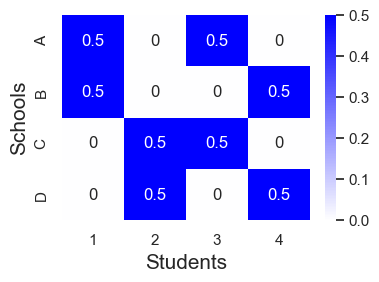

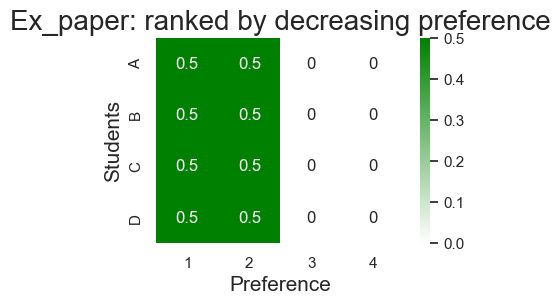

<Figure size 400x266.667 with 0 Axes>

In [86]:
# Visualize the solution
q.visualize()


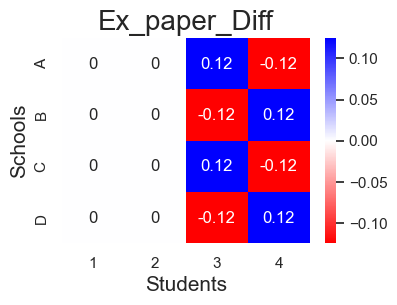

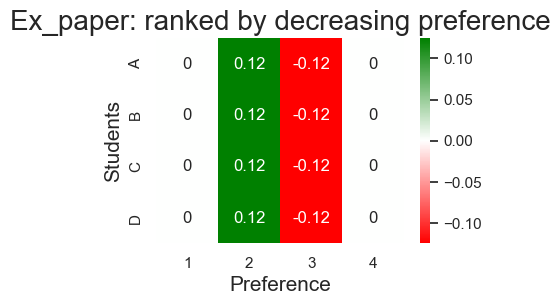

<Figure size 400x266.667 with 0 Axes>

In [104]:
# Asses the difference
diff = Assignment(MyData, q.assignment - p, "Ex_paper_Diff")
diff.visualize()

In [70]:
MyData.rank_pref

array([[0., 3., 1., 2.],
       [0., 3., 2., 1.],
       [3., 0., 1., 2.],
       [3., 0., 2., 1.]])

## Appendix: minimal working code pulp

In [ ]:
# Example of a simple MILP formulation in Gurobi 

from pulp import LpProblem, LpVariable, LpMaximize, GUROBI

# Define a simple problem
prob = LpProblem("SimpleProblem", LpMaximize)

# Define variables
x = LpVariable("x", lowBound=0)  # x >= 0
y = LpVariable("y", lowBound=0)  # y >= 0

# Objective Function
prob += 3 * x + 2 * y, "Objective"

# Constraints
prob += 2 * x + y <= 20, "Constraint 1"
prob += 4 * x + 3 * y <= 50, "Constraint 2"

# Solve using Gurobi API
prob.solve(GUROBI())

# Print the results
print(f"Status: {prob.status}")
print(f"x = {x.varValue}")
print(f"y = {y.varValue}")
prob.writeLP("Test.lp")
